

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/train/mountain/art1131.jpg?raw=1)|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/validation/forest/cdmc317.jpg?raw=1)|

The problem is relatively difficult given that the sample is tiny: about 350 observations per class. However, this sample size might be something that you can expect when prototyping an image classification problem/solution at work Get accustomed to evaluating several different possible models.

# Pre-Trained Model
<a id="p1"></a>

Load a pre-trained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` = False parameter in `ResNet50` will remove the fully connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to add additional full connected layers to our model. We removed the top layers, and we removed all previous fully connected layers. In other words, we kept only the feature processing portions of our network. The `GlobalAveragePooling2D` layer functions as a fancy flatten function by taking the average of each of the last convolutional layer outputs (two dimensional still). 

```python
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into NumPy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pre-trained layers from resnet
4. Report your model's accuracy

-----

# GPU on Colab

If you're working on Colab, you only have access to 2 processors, so your model training will be slow. However, if you turn on the GPU instance that you have access to, your model training will be faster!

[**Instructions for turning on GPU on Colab**](https://colab.research.google.com/notebooks/gpu.ipynb)

------

## Load in Data

Loading data is surprisingly more complicated than it seems because you are working with directories of images instead of a single file. 

This boilerplate will help you download a zipped version of the directory of images. The directory is organized into **train** and **validation** directories which you can use inside an `ImageGenerator` class to stream batches of images through your model.  



In [1]:
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import tensorflow as tf
import os

import numpy as np
import tensorflow as tf

# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model # This is the functional API

# from tensorflow.keras import datasets
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# from keras.preprocessing.image import array_to_img, img_to_array, load_img

In [2]:
%matplotlib inline
%load_ext tensorboard

In [ ]:
# Clear any tensorboard logs from previous runs
!rm -rf ./logs/

### Download & Summarize the Data

This step is completed for you. Just run the cells and review the results. 

In [2]:
# # data url
# _URL = 'https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data.zip?raw=true'

# # download data and save to `file_name`
# file_name = './data.zip'
# path_to_zip = tf.keras.utils.get_file(file_name, origin=_URL, extract=True,cache_dir='/content')

path_to_zip = 'C:/Users/ISHMO_CT\Downloads/Bloomtech/learn_neural/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/data.zip'

# get absolute path to location of the data that we just downloaded
PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

In [3]:
# protip: go to your terminal and paste the output below and cd into it
# explore it a bit...we'll come back to this later - muahahaha!!!
PATH

'C:/Users/ISHMO_CT\\Downloads/Bloomtech/learn_neural/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks\\data'

In [4]:
%ls /content/datasets/./data

Parameter format not correct - "content".


In [6]:
# create train data dir path
train_dir = os.path.join(PATH, 'train')

# create validation data dir path
validation_dir = os.path.join(PATH, 'validation')

In [7]:
# train directory with mountian data sub-dir 
train_mountain_dir = os.path.join(train_dir, 'mountain') 

# train directory with forest data sub-dir 
train_forest_dir = os.path.join(train_dir, 'forest')  

# validation directory with mountain data sub-dir 
validation_mountain_dir = os.path.join(validation_dir, 'mountain')  

# validation directory with forest data sub-dir 
validation_forest_dir = os.path.join(validation_dir, 'forest')  

In [8]:
# get the number of samples in each of the sub-dir 
num_mountain_tr = len(os.listdir(train_mountain_dir))
num_forest_tr = len(os.listdir(train_forest_dir))

num_mountain_val = len(os.listdir(validation_mountain_dir))
num_forest_val = len(os.listdir(validation_forest_dir))

# get the total number of samples for the train and validation sets
total_train = num_mountain_tr + num_forest_tr
total_val = num_mountain_val + num_forest_val

In [9]:
print('total training mountain images:', num_mountain_tr)
print('total training forest images:', num_forest_tr)

print('total validation mountain images:', num_mountain_val)
print('total validation forest images:', num_forest_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training mountain images: 252
total training forest images: 268
total validation mountain images: 123
total validation forest images: 60
--
Total training images: 520
Total validation images: 183


---

### Use Keras `ImageDataGenerator` to Process the Data

This step is completed for you, but please review the code. The `ImageDataGenerator` class reads in batches of data from a directory and passes them to the model one batch at a time. Like large text files, this method is advantageous because it stifles the need to load many images into memory.

At this point you should review the documentation for the [Keras ImageDataGenerator Class](https://keras.io/preprocessing/image/#imagedatagenerator-class). <br>
You'll expand its use in the next section.

In [12]:
batch_size = 16
epochs = 10 # feel free to change this value only after you've gone through the notebook once  
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [13]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator can rescale data from within 
max_pixel_val = 255.
rescale = 1./max_pixel_val

# Generator for our training data
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale) 
                                           
# Generator for our validation data                                           
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale) 

In [14]:
# Takes the path to a directory and generates batches of augmented data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary', 
                                                           color_mode='rgb')

Found 520 images belonging to 2 classes.


Image shape: (224, 224, 3)
Class indices: {'forest': 0, 'mountain': 1}
Number of classes: 2
Batch size: 16
Total number of samples: 520


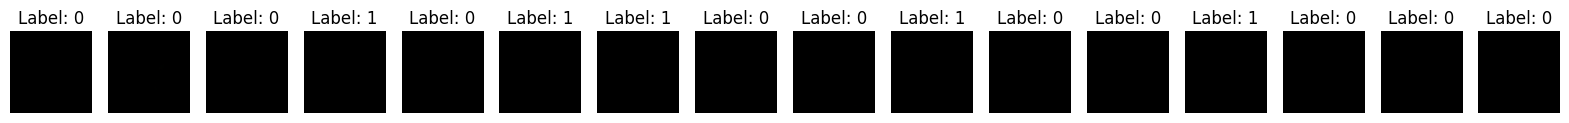

In [15]:
# explore some of `train_data_gen` attributes to get a sense of what this object can do for you
# YOUR CODE HERE
# Explore some of `train_data_gen` attributes
print("Image shape:", train_data_gen.image_shape)
print("Class indices:", train_data_gen.class_indices)
print("Number of classes:", train_data_gen.num_classes)
print("Batch size:", train_data_gen.batch_size)
print("Total number of samples:", train_data_gen.samples)

# Display a batch of images and their labels
import matplotlib.pyplot as plt

sample_batch = next(train_data_gen)
images, labels = sample_batch

fig, axes = plt.subplots(1, batch_size, figsize=(20, 20))
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.astype('uint8'))
    ax.set_title(f'Label: {int(label)}')
    ax.axis('off')
plt.show()


In [16]:
# Takes the path to a directory & generates batches of augmented data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary', 
                                                              color_mode='rgb')

Found 182 images belonging to 2 classes.


Image shape: (224, 224, 3)
Class indices: {'forest': 0, 'mountain': 1}
Number of classes: 2
Batch size: 16
Total number of samples: 182


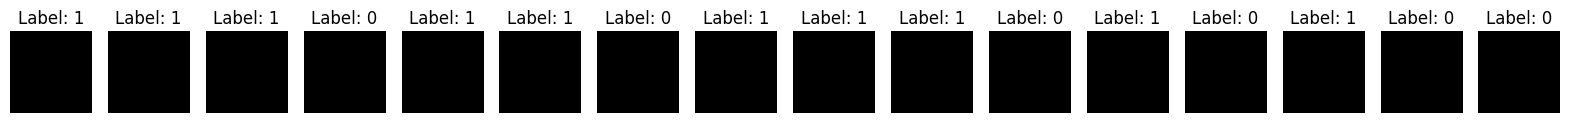

In [17]:
# explore some of `val_data_gen` attributes to get a sense of what this object can do for you
# YOUR CODE HERE

# Explore some of `val_data_gen` attributes
print("Image shape:", val_data_gen.image_shape)
print("Class indices:", val_data_gen.class_indices)
print("Number of classes:", val_data_gen.num_classes)
print("Batch size:", val_data_gen.batch_size)
print("Total number of samples:", val_data_gen.samples)

# Display a batch of images and their labels from the validation data
import matplotlib.pyplot as plt

val_sample_batch = next(val_data_gen)
val_images, val_labels = val_sample_batch

fig, axes = plt.subplots(1, batch_size, figsize=(20, 20))
for img, label, ax in zip(val_images, val_labels, axes):
    ax.imshow(img.astype('uint8'))
    ax.set_title(f'Label: {int(label)}')
    ax.axis('off')
plt.show()


_____
## Instantiate Model

Here your job is to take the python code at the beginning of the notebook (in the markdown cell) and turn it into working code. 

Most of the code that you'll need to build a model is in that markdown cell, though you'll still need to compile the model.

Some pseudo-code is provided as a guide. 

In [19]:
# load in the pre-trained model
# YOUR CODE HERE
# raise NotImplementedError()
resnet = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# don't Freeze the ResNet50 layers
for layer in resnet.layers:
    layer.trainable = True

# Add custom layers on top of the pre-trained ResNet50 base
x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model = tf.keras.models.Model(inputs=resnet.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

### "Freeze" all the pretrained resnet50 weights and biases 
so they will *not* be updated by gradient descent and backpropagation during training. <br>
Your model will train only the additional dense layers the classification part that you add to it below. <br>This is the essence of **Transfer Learning**: adapting a pre-trained model to a new data set that is different from the data used to train the mode.

In [20]:
# YOUR CODE HERE
# raise NotImplementedError()
# Load the pre-trained ResNet50 model without the top fully connected layers
resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze all layers of the ResNet50 model
for layer in resnet.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained ResNet50 base
x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model = tf.keras.models.Model(inputs=resnet.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# take the model output layer as a starting point

# take a global average pool

# add a trainable hidden layer with 1024 nodes 

# add a trainable output layer 

# put it all together using the Keras's Model api


# YOUR CODE HERE
# raise NotImplementedError()

# Load the pre-trained ResNet50 model without the top fully connected layers
resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze all layers of the ResNet50 model
for layer in resnet.layers:
    layer.trainable = False

# Start with the output of the ResNet50 model
x = resnet.output

# Apply Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a fully connected hidden layer with 1024 nodes
x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Add the output layer with a sigmoid activation function for binary classification
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model using the Keras Model API
model = tf.keras.models.Model(inputs=resnet.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to check the architecture
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
# the only code that is missing is the compile method 

# YOUR CODE HERE
# raise NotImplementedError() 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Use the Adam optimizer with a small learning rate
              loss='binary_crossentropy',  # Binary cross-entropy loss function for binary classification
              metrics=['accuracy'])  # Metric to evaluate the performance of the model

## Fit Model

In [23]:
# include the callback into the fit method
# we'll launch tensorboard in the last section
logdir = os.path.join("logs", "resnet_model")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [25]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    # workers=1, # num should be 1 or 2 processors less than the total number of process on your machine
    callbacks=[tensorboard_callback]
)

Epoch 1/10


c:\Users\ISHMO_CT\.virtualenvs\learn_neural-7s1zIBU3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5391 - loss: 0.7211 - val_accuracy: 0.3864 - val_loss: 0.7099
Epoch 2/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3750 - loss: 0.7074

C:\ProgramData\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.3750 - loss: 0.7074 - val_accuracy: 0.3333 - val_loss: 0.7487
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5434 - loss: 0.6695 - val_accuracy: 0.3409 - val_loss: 0.8284
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.5625 - loss: 0.6320 - val_accuracy: 0.0000e+00 - val_loss: 1.1668
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5767 - loss: 0.6738 - val_accuracy: 0.7273 - val_loss: 0.6156
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.6875 - loss: 0.6188 - val_accuracy: 0.6667 - val_loss: 0.6640
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6883 - loss: 0.6120 - val_accuracy: 0.7727 - val_loss: 0.6236
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 1.0000 - loss: 0.5759 - val_accuracy: 0.6667 - val_loss: 0.6257
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7808 - loss: 0.5954 - val_accuracy: 0.7557 - val_los

## Take Away

The above task is an exercise in using a pre-trained model in the context of **Transfer Learning**. 

**Transfer Learning** happens when you take a model trained on a data set $A$ and apply it to the data set $B$. You may or may not choose to re-train the model.

We loaded in a pre-trained model (meaning the weight values have been optimized in a previous fit) and updated the values of the weights by re-training them. Note that we didn't reset the model weights; we just continued their training on a different dataset, our data set. 


-----
# Custom CNN Model

In this step, write and train your convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

**Protip:** You'll be creating a 2nd instance of this same model in the next section. Instead of copying and pasting all this code, embed it in a `def create_model()` that returns a compiled model. 

Free to reference the custom CNN model that we built together in the guided project. 

In [ ]:
def create_model():
    """
    Since we'll be using this model again in the next section, it's useful to create a function 
    that returns a compiled model.
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# instantiate a model 
model = create_model()

In [ ]:
model.summary()

In [ ]:
# include this callback in your fit method
# we'll launch tensorboard in the last section
logdir = os.path.join("logs", "baseline_model")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Fit Model
epochs = 10
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    workers=10, # num should be 1 or 2 processors less than the total number of process on your machine 
    callbacks=[tensorboard_callback]
)

------
# Custom CNN Model with Image Augmentation

To simulate an increase in an image sample, you can apply image manipulation techniques: cropping, rotation, stretching, etc. <br>
Luckily, Keras has some handy functions for us to apply these techniques to our mountain and forest example. In addition, you should be able to modify our image generator for the problem. Check out these resources to help you get started: 

1. [**Keras ImageGenerator Class**](https://keras.io/preprocessing/image/#imagedatagenerator-class) documentation for the tool that we need to use to augment our images
2. [**Building a powerful image classifier with very little data**](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) This is essentially a tutorial on using the ImageGenerator class to create augmented images. You can essentially copy and paste the relevant code, though don't do that blindly! 
 

### Use ImageDataGenerator to Create Augmented Data

Use the parameters for ImageDataGenerator that will enable you to generate an augmented version of images that we already have. Here are some of the relevant parameters to help you get started. 

- rescale
- shear_range
- zoom_range
- horizontal_flip

### Only Create Augmented Images for the Training Data

We want to be able to make a comparison with the same CNN model (or models) from above. 

To do that, we will augment the training data but not the validation data. Then we'll compare the accuracy and loss on the validation set. 

That way, we are comparing the performance of the same model architecture on the same test set; the only difference will be the augmented training data.Therefore, we'll be in a position to determine if augmenting our training data helped improve our model performance. 

This is an example of a controlled experiment.

In [ ]:
batch_size = 16

# ImageDataGenerator can rescale data from within 
max_pixel_val = 255.
rescale = 1./max_pixel_val

In [ ]:
# YOUR CODE HERE
# create an ImageDataGenerator instance - save result to `train_datagen_aug`
raise NotImplementedError()

In [ ]:
# call the .flow_from_directory() method - save result to `train_data_gen_aug`
# protip: be mindful of the parameters

# YOUR CODE HERE
raise NotImplementedError()

### Augment a Single Image

Now that you have instantiated the `ImageDataGenerator` object that created augmented images for the training set.  Let's visual those augmented images to get a sense of what augmented images look like! 


In [ ]:
# filename of image that we will augment
# this is just one of 100's of training images to choose from
# feel free to explore the training data directories and choose another image
# this image was selected from the mountain images 
img_to_aug = "art1131.jpg"

# replace with YOUR home directory name 
home_dir = "alexanderbarriga"

# create absolute file path to image file
path_to_single_img = "./datasets/data/train/mountain/{0}".format(img_to_aug)

path_to_single_img

In [ ]:
# load in image from file and reshape
img = load_img(path_to_single_img)  
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)  

Create a temporary directory to store the augmented images that we will create to visualize. 

In [ ]:
# this is a terminal command that we are running in the notebook by including a `!` 
# feel free to delete this temp dir after visualizing the aug images below
# you only need to create this dir once
!mkdir preview_img

Use the training data generator we just created to create 20 augmented images of the same original image.

In [ ]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview_img` directory

# create 20 aug images
n_aug_imgs_to_create = 20
i = 0
for batch in train_datagen_aug.flow(x, 
                                    batch_size=1,
                                    save_to_dir='preview_img', 
                                    save_prefix='art', 
                                    save_format='jpeg'):
    i += 1
    if i > n_aug_imgs_to_create:
        break  # otherwise the generator would loop indefinitely

In [ ]:
# create list populated with augmented image filenames
file_names = [f for f in listdir("preview_img") if isfile(join("preview_img", f))]

In [ ]:
# load and prep images into a list 
aug_imgs = []
for filename in file_names:

    img = load_img("preview_img/{}".format(filename)) 
    a_img = img_to_array(img)  
    a_img = a_img.reshape((1,) + x.shape) 
    aug_imgs.append(a_img)

In [ ]:
# notice that we are playing with a rank 5 tensor 
# we can ignore the first two numbers
a_img.shape

In [ ]:
# the last 3 numbers have the actual image data
# (num 1, num 2, num 3) = (img height, img width, color channels)
a_img[0][0].shape

### Visualize Augmented Images

Notice that the augmented images are just the original image with slight changes. For example, one image might be flipped to the y-axis or shifted along the x or y-axis, and the right-hand side might be clipped, the image might be scaled up or down, or some combination of changes. 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for i, a_img in enumerate(aug_imgs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a_img[0][0]/255.)

plt.show()

Now the real question is, does any of this ultimately matter? For example, do these changes help our model's ability to learn and generalize better? Well, let's go ahead and run that experiment. 

-----

## Re-train Your Custom CNN Model Using the Augmented Dataset

We have created a data generator that creates augmented versions of the training images (and not the validation images). Thus, we can create a new instance of our custom CNN model with the same architecture, same parameters such as batch size and epochs, and see if augmented data helps. 

In [ ]:
aug_model = create_model()

In [ ]:
aug_model.summary()

In [ ]:
logdir = os.path.join("logs", "aug_model")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Fit Model

epochs = 10

history = aug_model.fit(
    train_data_gen_aug,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    workers=10, # num should be 1 or 2 processors less than the total number of process on your machine 
    callbacks=[tensorboard_callback]
)

-----

# Compare Model Results

In [ ]:
%tensorboard --logdir logs

------

### Time for Questions 

Take a look at the `epoch_accuracy` plot and answer the following questions. 

Optionally move the `smoothing` slider all the way to zero to view the raw scores. 

By the way, your results may look different than your classmates depending on how you choose to build your custom CNN model. 


**Question 1:** Which of the three models performed the best? 

YOUR ANSWER HERE

**Question 2:** Did augmenting the training data help our custom CNN model improve its score? If so, why, if not, why not?

YOUR ANSWER HERE

**Question 3:** Could one or more of the three models benefit from training on more than ten epochs? If so, why, if not, why not?

YOUR ANSWER HERE

**Question 4:** If you didn't use regularization for your custom CNN, do you think the baseline model and the aug model could improve their scores if regularization was used? If so, why, if not, why not?

Consider reviewing your Sprint 2 Module Assignment 2 experimental results on regularization. 

YOUR ANSWER HERE

-----

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g., download images of parties, recognize all that contain balloons)
- Check out [other available pre-trained networks](https://tfhub.dev), try some, and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g., [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed into your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution-based object detection system, focused on inference speed (for applications too e.g., self-driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language